path train: '/kaggle/input/indonesian-food/dataset/train'<br>
path test: '/kaggle/input/indonesian-food/dataset/test'<br>
path valid: '/kaggle/input/indonesian-food/dataset/valid'<br>
ada 4 kelas: bakso gado rendang sate

In [1]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow.keras.layers as tflayers

# Model Training
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as tflayers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import regularizers

# Model Hypertunning
!pip install Keras-Preprocessing
cls()
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CLASS_NAMES = ['bakso', 'gado', 'rendang', 'sate']
TRAINING_DIR = "/kaggle/input/indonesian-food/dataset/train"
VALIDATION_DIR = "/kaggle/input/indonesian-food/dataset/test"
TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'

In [3]:
# with tf.device('/gpu:0'):
model = Sequential()

# base_model = Xception(
#     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
#     include_top=False,
#     weights='imagenet'
# )
# model.add(base_model)
# model.add(tf.keras.layers.GlobalAveragePooling2D())

# nontransfer learning
model.add(tflayers.Rescaling(1./255, offset=-1))
model.add(tflayers.Conv2D(16, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(32, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(64, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(128, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))

model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(512, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Flatten())

# Tune the hyperparameters for the Dense layer
model.add(Dense(512, activation='relu'))
model.add(tflayers.Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Print the model summary
# model.summary()

In [4]:
initial_LR = 6e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_LR)

model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [5]:
IMAGES_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.4)
])

train_generator = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMAGES_SIZE
    
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMAGES_SIZE
    
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMAGES_SIZE,
    shuffle=False
)

Found 7887 files belonging to 4 classes.
Found 866 files belonging to 4 classes.
Found 343 files belonging to 4 classes.


In [6]:
train_generator = train_generator.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance
train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Perform hyperparameter tuning
# tuner.search(
#     train_generator, 
#     validation_data=validation_generator, 
#     epochs=10
# #     steps_per_epoch=100
# )

# Get the best hyperparameters and build the final model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)

In [8]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator, 
    callbacks=[early_stopping], 
    epochs=100 ,
    verbose=1, 
    validation_data = validation_generator,
#     steps_per_epoch = 1
)

# val_loss_per_epoch = history.history['val_accuracy']
# best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
124/124 [==============================] - 92s 647ms/step - loss: 1.3416 - accuracy: 0.3279 - val_loss: 1.2616 - val_accuracy: 0.4053
Epoch 2/100
124/124 [==============================] - 68s 541ms/step - loss: 1.0746 - accuracy: 0.4999 - val_loss: 1.0124 - val_accuracy: 0.5231
Epoch 3/100
124/124 [==============================] - 69s 546ms/step - loss: 0.9701 - accuracy: 0.5603 - val_loss: 0.9688 - val_accuracy: 0.5624
Epoch 4/100
124/124 [==============================] - 68s 540ms/step - loss: 0.8999 - accuracy: 0.6043 - val_loss: 0.9522 - val_accuracy: 0.5924
Epoch 5/100
124/124 [==============================] - 69s 546ms/step - loss: 0.8432 - accuracy: 0.6345 - val_loss: 0.9231 - val_accuracy: 0.6062
Epoch 6/100
124/124 [==============================] - 71s 564ms/step - loss: 0.8034 - accuracy: 0.6589 - val_loss: 0.7897 - val_accuracy: 0.6490
Epoch 7/100
124/124 [==============================] - 69s 546ms/step - loss: 0.7660 - accuracy: 0.6823 - val_loss: 0.6802 -

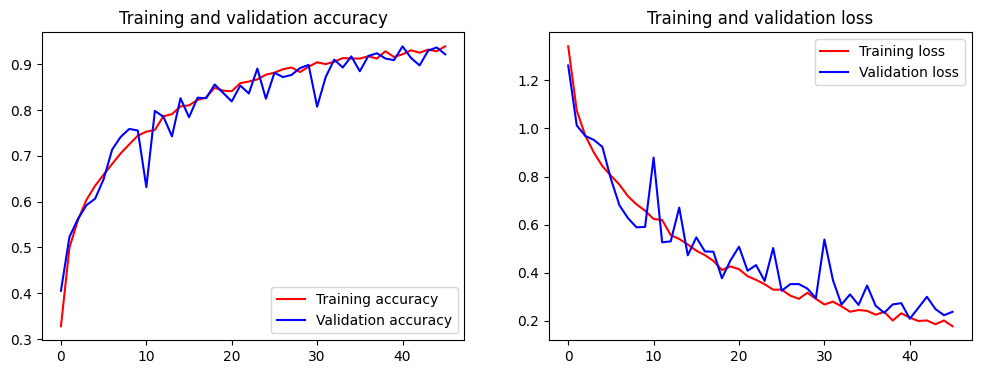

In [9]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [10]:
from datetime import datetime
# current date and time
now = datetime.now()

time_stamp = datetime.timestamp(now)
name = f'model-Bloss-{time_stamp}'
model.save(f'{name}.h5')

In [11]:
# save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoints', options=save_locally)

In [12]:
# # hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model
# historyFinal = model.fit(
#     train_generator, 
#     epochs=best_epoch, 
#     verbose=1,
#     validation_data = validation_generator,
#     callbacks=[checkpoints_cb],
# #     steps_per_epoch = 10
# )

In [13]:
# eval_result = hypermodel.evaluate(img_test, label_test)
# print("[test loss, test accuracy]:", eval_result)

In [14]:
# import matplotlib.pyplot as plt

# # Plot the results
# acc = historyFinal.history['accuracy']
# val_acc = historyFinal.history['val_accuracy']
# loss = historyFinal.history['loss']
# val_loss = historyFinal.history['val_loss']

# epochs = range(len(acc))

# figure, axis = plt.subplots(1, 2, figsize=(12, 4))

# axis[0].plot(epochs, acc, 'r', label='Training accuracy')
# axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
# axis[0].set_title("Training and validation accuracy")
# axis[0].legend(loc=0)

# axis[1].plot(epochs, loss, 'r', label='Training loss')
# axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
# axis[1].set_title("Training and validation loss")
# axis[1].legend(loc=0)


# plt.show()

In [15]:
# # Define the path to the directory where the checkpoints were saved
# checkpoint_dir = './checkpoints'

# # Load the best checkpoint using tf.keras.models.load_model()
# best_model = tf.keras.models.load_model(checkpoint_dir)

In [16]:
# from datetime import datetime
# # current date and time
# now = datetime.now()

# time_stamp = datetime.timestamp(now)
# name = f'model-train-{time_stamp}'
# best_model.save(f'{name}.h5')

In [17]:
# import tensorflow as tf
# best_model = tf.keras.models.load_model(
#     '/kaggle/input/models/model-train-1685722885.101213.h5'
# )
# model = tf.keras.models.load_model(
#     '/kaggle/input/models/model-Bloss-1685721375.749981.h5'
# )

In [18]:
test_loss_loss, test_acc_loss = model.evaluate(test_dataset, verbose=0)

# test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)
# print(
#     "model train\n",
#     "Loss    : {:.4}\n".format(test_loss), 
#     "Accuracy: {:.4}%\n".format(test_acc*100)
# )
print(
    "\nmodel Bloss\n",
    "Loss    : {:.4}\n".format(test_loss_loss), 
    "Accuracy: {:.4}%\n".format(test_acc_loss*100)
)


model Bloss
 Loss    : 0.5758
 Accuracy: 80.47%



In [19]:
def auto_testing(TEST_DIR, best_model):
    for dirname, _, filenames in os.walk(TEST_DIR):
        if dirname is not TEST_DIR:
            last_dir = os.path.basename(os.path.normpath(dirname))
            correct = 0
            report = None
            for idx, filename in enumerate(filenames):
                path = filename

                img = load_img(os.path.join(
                    os.path.join(TEST_DIR, dirname), filename), target_size=(IMAGE_SIZE, IMAGE_SIZE))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                images = np.vstack([x])
                classes = best_model.predict(images, batch_size=128, verbose=0)
                score = tf.nn.softmax(classes[0])

                predicted_class = np.argmax(score)
                predicted_class_name = class_names[np.argmax(score)]

                if(last_dir==predicted_class_name): correct += 1
    #             print("Image: ", filename)
    #             print(
    #                 "This image most likely belongs to {} with a {:.2f} percent confidence.\n"
    #                 .format(predicted_class_name, 100 * np.max(score))
    #             )

            print(f'untuk folder {last_dir}')
            print("Jumlah data",len(os.listdir(os.path.join(TEST_DIR, dirname))))
            print("Jumlah data benar", correct)
            print(
                "Akurasi {:.2f}\n"
                .format(100*(correct/len(os.listdir(os.path.join(TEST_DIR, dirname)))))
            )

In [20]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

true_labels = np.concatenate([y for _, y in test_dataset], axis=0)

true_labels = to_categorical(true_labels, num_classes=4)

class_names = CLASS_NAMES
print(class_names)
 
# predicting images
TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'
# auto_testing(TEST_DIR, best_model)
print('===============================')
auto_testing(TEST_DIR, model)



['bakso', 'gado', 'rendang', 'sate']
untuk folder sate
Jumlah data 89
Jumlah data benar 68
Akurasi 76.40

untuk folder bakso
Jumlah data 89
Jumlah data benar 78
Akurasi 87.64

untuk folder gado
Jumlah data 87
Jumlah data benar 63
Akurasi 72.41

untuk folder rendang
Jumlah data 78
Jumlah data benar 63
Akurasi 80.77



In [21]:
# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(CLASS_NAMES.index(class_name))
    return np.array(images), np.array(labels)

In [22]:
# Make predictions
test_dataset, test_label = load_images(TEST_DIR)

baseline_pred = np.argmax(model.predict(test_dataset, verbose=0), axis=-1)
# best_pred = np.argmax(mobile_net_model.predict(X_test, verbose=0), axis=-1)

# Evaluate prediction : Precision
baseline_pre = precision_score(test_label, baseline_pred, average='macro', zero_division=0)
# best_pre = precision_score(y_test, best_pred, average='macro')

# Evaluate prediction : Recall
baseline_recall = recall_score(test_label, baseline_pred, average='macro', zero_division=0)
# best_recall = recall_score(y_test, best_pred, average='macro')

# Evaluate prediction : F1 Score
baseline_f1 = f1_score(test_label, baseline_pred, average='macro', zero_division=0)
# best_f1 = f1_score(y_test, best_pred, average='macro')

print("{:20}".format("Baseline Performance"))
print("{:10} : {:.5}".format("Precision", baseline_pre))
print("{:10} : {:.5}".format("Recall", baseline_recall))
print("{:10} : {:.5}".format("F1 Score", baseline_f1))

print('\n',classification_report(test_label, baseline_pred, zero_division=0))

Baseline Performance
Precision  : 0.056851
Recall     : 0.25
F1 Score   : 0.092637

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.00      0.00      0.00        87
           2       0.23      1.00      0.37        78
           3       0.00      0.00      0.00        89

    accuracy                           0.23       343
   macro avg       0.06      0.25      0.09       343
weighted avg       0.05      0.23      0.08       343

